# Mise en commun des données téléchargées

## Objectif

L'objectif de ce notebook est de mettre en commun toutes les données de historiques de toutes les paires de devise à disposition. Il sera aussi nécessaire de changer l'intervalle de temps entre les valeurs. Lors du téléchargement en partie 0, nous avons obtenus les données avec le tick M1. IL nous faudra alors le passer en D1 pour faire des prédictions quotidiennes.

## Import des libraires

In [1]:
import os  # for path dirs and files
import glob  # to recover the files after downloading them

# to deal with data
import numpy as np
import pandas as pd

# plot the results
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## Récupération de tous les fichiers .csv
Avant de commencer à mettre en commun nos données brutes dans un seul fichier, il faut récupérer tous les fichiers indépendants. 

In [2]:
# get all the files we have downloaded
files = glob.glob(os.path.join('.', 'data', '**', 'histdata', '*.csv'))

# take one for the exemple during the process
file = files[0]
pair = file.split(os.sep)[-1].split('.')[0].split('_')[-3]
print(f'There are {len(files)} and the first one is "{file} from pair" {pair}')

There are 904 and the first one is ".\data\AUDCAD\histdata\DAT_ASCII_AUDCAD_M1_2007.csv from pair" AUDCAD


## Changement d'intervalle de temps (M1 --> D1)

Notre premier objectif est de réduire l'intervalle de temps des ticks de nos fichiers .csv. Avant cela, jettons un coup d'oeil à sa composition qui est décrite comme ci-dessous: (https://www.histdata.com/f-a-q/data-files-detailed-specification/)
```
Row Fields:
DateTime Stamp;Bar OPEN Bid Quote;Bar HIGH Bid Quote;Bar LOW Bid Quote;Bar CLOSE Bid Quote;Volume

DateTime Stamp Format:
YYYYMMDD HHMMSSNNN

Legend:
YYYY – Year
MM – Month (01 to 12)
DD – Day of the Month
HH – Hour of the day (in 24h format)
MM – Minute
SS – Second
NNN – Millisecond
```

On y ira étape par étape. La première consiste à se faire une petite fonction pour importer le csv d'une paire de devise pour une année donnée

In [3]:
def file_to_df(file):
    # read a file a convert it into a dataframe with according columns
    df = pd.read_csv(file, header=None, sep=';')
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
    return df

df = file_to_df(file)
df

,datetime,open,high,low,close,volume
0,20070930 170000,0.8832,0.8832,0.8832,0.8832,0
1,20071007 170000,0.8823,0.8823,0.8823,0.8823,0
2,20071007 170100,0.8822,0.8822,0.8822,0.8822,0
3,20071007 170200,0.8822,0.8823,0.8822,0.8822,0
4,20071014 170000,0.8799,0.8799,0.8799,0.8799,0
...,...,...,...,...,...,...
65744,20071231 163800,0.8730,0.8730,0.8730,0.8730,0
65745,20071231 163900,0.8730,0.8730,0.8730,0.8730,0
65746,20071231 164000,0.8731,0.8734,0.8731,0.8734,0
65747,20071231 164400,0.8735,0.8736,0.8735,0.8736,0


On note que les volumes ne sont pas précisés. Ce n'est pas un problème pour notre étude, nous n'en aurons pas besoin. 

Il faut donc reformater la date pour passer en M1 en D1

In [4]:
def M1_to_D1(df):
    # split the day and get the hour in the day to sort the dataframe
    df[['day', 'M1']] = df.datetime.str.split(' ', expand=True)
    
    # sort the dataframe by time
    df = df.sort_values(['day', 'M1'])
    
    # aggregate only on the days to have a D1 tick
    df = df.groupby(['day']).agg({
        'open':  'first', 
        'high':  'max', 
        'low':   'min', 
        'close': 'last'
        },
    ).reset_index(drop=False)
    
    # convert the string into a real datetime
    df['day'] = pd.to_datetime(df['day'])
    
    return df

df = M1_to_D1(df)
df

,day,open,high,low,close
0,2007-09-30,0.8832,0.8832,0.8832,0.8832
1,2007-10-07,0.8823,0.8823,0.8822,0.8822
2,2007-10-14,0.8799,0.8799,0.8799,0.8799
3,2007-10-21,0.8598,0.8599,0.8594,0.8594
4,2007-10-22,0.8620,0.8700,0.8607,0.8686
...,...,...,...,...,...
59,2007-12-26,0.8597,0.8611,0.8568,0.8590
60,2007-12-27,0.8591,0.8626,0.8562,0.8586
61,2007-12-28,0.8585,0.8615,0.8543,0.8601
62,2007-12-30,0.8604,0.8630,0.8582,0.8624


Faison un sanity check en affichant la courbe de l'année en question pour cette paire de devise

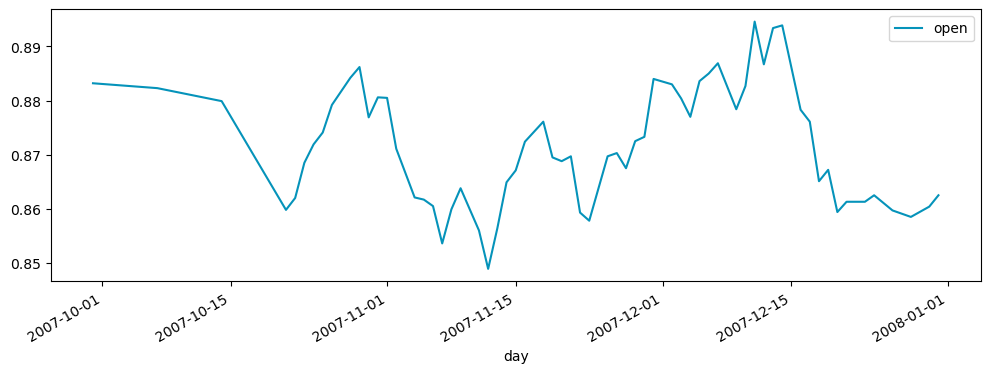

In [5]:
df['day'] = pd.to_datetime(df.day)
df.plot('day', 'open', color='#0593ba')
pass

On remarque par contre qu'il y a des données manquantes puisque les lignes ne sont pas à intervalle régulier. 
Il nous faut donc premièrement une fonction pour ajouter toutes les dates manquantes entre la première et la dernière du dataframe

In [6]:
def add_missing_days(df):
    # get all the days bewteen the minimum and maximum date of the dataframe. 
    day_range = pd.date_range(df.day.min(), df.day.max(), freq='D')
    # remove the weekend days because the forex echange is not open on these days
    day_range = day_range[~day_range.day_name().isin(['Saturday', 'Sunday'])]
    
    # we can know reindex the dataframe to have every single day
    # and we fill the missing ones with 0 (impossible value because of the ratio)
    df = df.set_index('day')
    df = df.reindex(day_range, fill_value=0)
    df = df.reset_index().rename(columns={'index': 'day'})

    return df
df = add_missing_days(df)

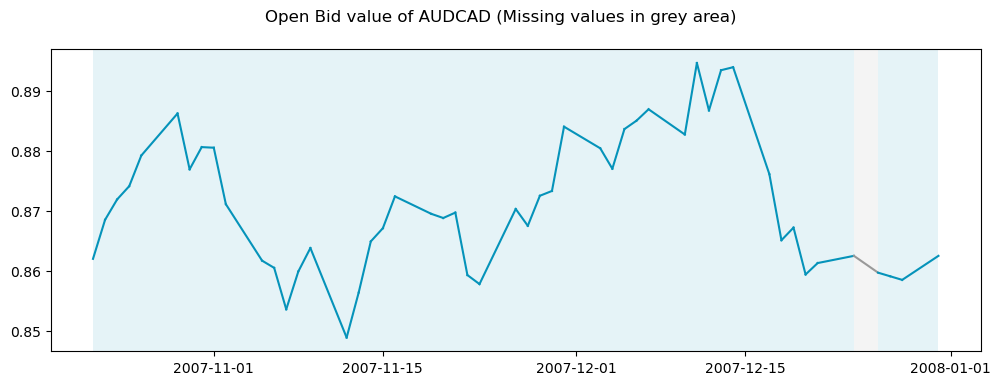

In [7]:
def plot_chart(df, plot_background=False, plot_missing=True):
    start = None  # start row on which we have no data
    last = None  # last row to have to remember to be able to plot from one day to another
    
    for row in df.itertuples():
        # if we identify an area where the data are missing we specify the start row as the last one (interpolation use)
        if not row.open and start is None:
            start = last
            stop = None
        
        # if there is no missing value BUT we are ending an area we there were only missing values (at least one)
        # we plot it differently as the normal plot from one day to another (row to row)
        if row.open and start is not None:
            if plot_background:
                plt.axvspan(start.day, row.day, facecolor='#999999', alpha=0.1)
            if plot_missing:
                plt.plot([last.day, row.day], [last.open, row.open], color='#999999')
            # set start to None as we are not anymore in a missing-value-area
            start = None 
            
        # else we plot the normal data (except for the first value because we are drawing lines from the last day)
        elif row.open and last is not None:
            if plot_background:
                plt.axvspan(last.day, row.day, facecolor='#0593ba', alpha=0.1)
            plt.plot([last.day, row.day], [last.open, row.open], color='#0593ba')
            
        # set the last row (at the condition it does not contain a missing value (0))
        if row.open:
            last = row
            
plot_chart(df, plot_background=True)
plt.suptitle(f'Open Bid value of {pair} (Missing values in grey area)')
pass

Les données manquantes sont vraiment un problème. Il existe un bon nombre de façon d'y remédier. Mais la manière la plus simple est d'utiliser une fonction d'interpolation entre les données existantes. 

De ce fait, nous utiliserons une interpolation quadratique d'ordre 2 (classique)

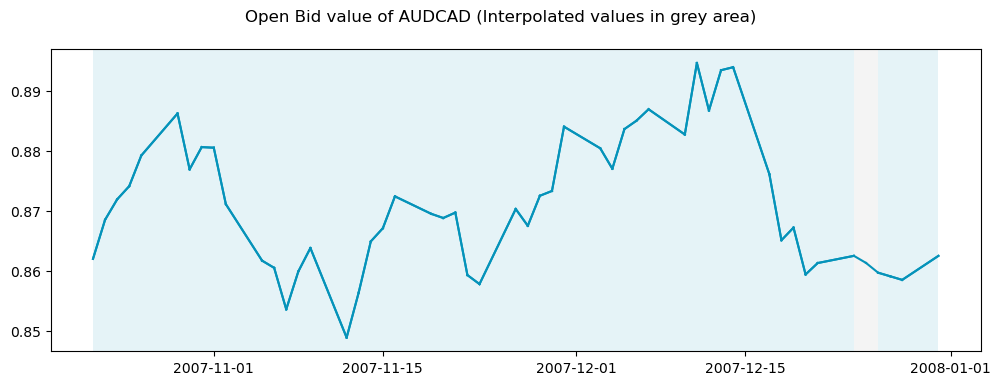

In [8]:
def interpolate(df, missing_value=0, method='quadratic', order=2):
    # replace missing values by nan values to be considerate by the interpolate() function from pandas
    df = df.replace(missing_value, np.nan)
    df = df.interpolate(method=method, order=order)
    return df

plot_chart(df, plot_background=True, plot_missing=False)
plot_chart(interpolate(df))

plt.suptitle(f'Open Bid value of {pair} (Interpolated values in grey area)')
pass

## Concaténation par paire de devise

Maintenant que nous avons toutes les fonctions à disposition avoir nos données en D1 de façon propre avec la gestion des données manquantes pour un fichier donné, nous pouvons passer à la concaténation des ensembles des fichiers appartenant à une paire de devise. 

Concrètement, pour chaque paire de devise, on a un ensemble de fichier, qui, je le rappelle sont l'historique pour une année précise. 
On rassemble alors tout cela dans un dictionnaire par devise. 

In [9]:
dict_files = {}
for file in files:
    # isolate the pair name
    pair = file.split(os.sep)[-1].split('.')[0].split('_')[-3]
    
    # add the file to the dictionnary (avoiding the KeyError of course)
    if pair in dict_files:
        dict_files[pair].append(file)
    else:
        dict_files[pair] = [file]
        
print(f'The pair {pair} contains the files:')
dict_files[pair]

The pair ZARJPY contains the files:


['.\\data\\ZARJPY\\histdata\\DAT_ASCII_ZARJPY_M1_2010.csv',
 '.\\data\\ZARJPY\\histdata\\DAT_ASCII_ZARJPY_M1_2011.csv',
 '.\\data\\ZARJPY\\histdata\\DAT_ASCII_ZARJPY_M1_2012.csv',
 '.\\data\\ZARJPY\\histdata\\DAT_ASCII_ZARJPY_M1_2013.csv',
 '.\\data\\ZARJPY\\histdata\\DAT_ASCII_ZARJPY_M1_2014.csv',
 '.\\data\\ZARJPY\\histdata\\DAT_ASCII_ZARJPY_M1_2015.csv',
 '.\\data\\ZARJPY\\histdata\\DAT_ASCII_ZARJPY_M1_2016.csv',
 '.\\data\\ZARJPY\\histdata\\DAT_ASCII_ZARJPY_M1_2017.csv',
 '.\\data\\ZARJPY\\histdata\\DAT_ASCII_ZARJPY_M1_2018.csv',
 '.\\data\\ZARJPY\\histdata\\DAT_ASCII_ZARJPY_M1_2019.csv',
 '.\\data\\ZARJPY\\histdata\\DAT_ASCII_ZARJPY_M1_2020.csv']

Toutes nos fonction sont en place pour créer un dataframe contenant toutes les données historiques d'une devise donnée à partir de la liste de ses fichiers. 
On peut alors créer une dernière fonction pour mettre en commun tout cela

In [10]:
def pair_files_to_df(files):
    df = pd.DataFrame()
    
    # we add each data contained in the files in the dataframe of the pair 
    for file in files:
        # get the data and convert it into D1 tick data
        file_df = file_to_df(file)
        file_df = M1_to_D1(file_df)
        # add the data to the pair's dataframe
        df = df.append(file_df, ignore_index=True)
    
    # deal with missing values adding the missing days 
    # and completing the values with an interpolation
    df = add_missing_days(df)
    df = interpolate(df)
    return df
df = pair_files_to_df(dict_files[pair])
df

,day,open,high,low,close
0,2010-11-15,11.700,11.810,11.660,11.760
1,2010-11-16,11.770,11.770,11.640,11.700
2,2010-11-17,11.690,11.820,11.630,11.730
3,2010-11-18,11.720,11.850,11.710,11.820
4,2010-11-19,11.810,11.850,11.710,11.780
...,...,...,...,...,...
2639,2020-12-25,7.067,7.068,6.976,7.054
2640,2020-12-28,7.100,7.115,7.055,7.086
2641,2020-12-29,7.085,7.108,7.016,7.036
2642,2020-12-30,7.037,7.075,7.001,7.051


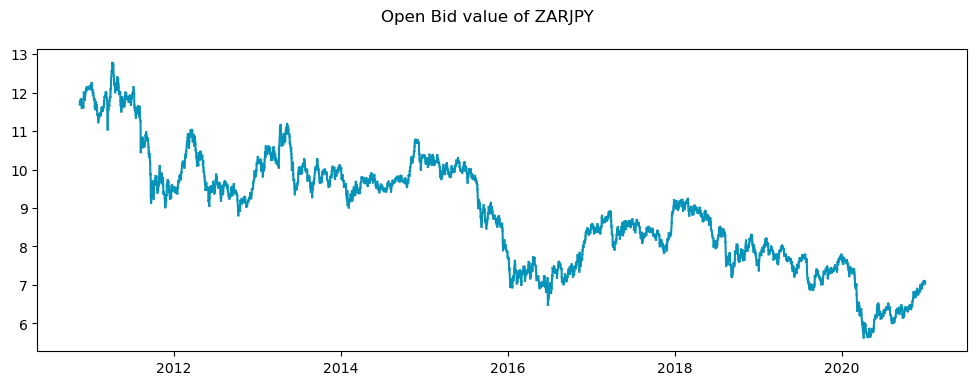

In [11]:
plot_chart(df)
plt.suptitle(f'Open Bid value of {pair}')
pass

## Concaténation des paires de devise

Enfin, il ne reste plus qu'une petite dernière fonction. Celle-ci concatène la concaténation par devise.
Donc on a une concaténation des données de toutes les devises au sein d'un dataframe unique.

In [12]:
def get_full_df(dict_files):
    df = pd.DataFrame()
    for i, (pair, files) in enumerate(dict_files.items()):
        print(f'Preprocessing {pair} pair files [{i+1}/{len(dict_files)}]...')
        
        # get the pair dataframe and add the column of the pair name before appending to the full dataframe
        pair_df = pair_files_to_df(files)
        pair_df['pair'] = pair
        df = df.append(pair_df, ignore_index=True)

    # set the "pair" column at the first position
    df = df[ ['pair'] + [ col for col in df.columns if col != 'pair' ] ]
    return df
df = get_full_df(dict_files)

Preprocessing AUDCAD pair files [1/66]...
Preprocessing AUDCHF pair files [2/66]...
Preprocessing AUDJPY pair files [3/66]...
Preprocessing AUDNZD pair files [4/66]...
Preprocessing AUDUSD pair files [5/66]...
Preprocessing AUXAUD pair files [6/66]...
Preprocessing BCOUSD pair files [7/66]...
Preprocessing CADCHF pair files [8/66]...
Preprocessing CADJPY pair files [9/66]...
Preprocessing CHFJPY pair files [10/66]...
Preprocessing ETXEUR pair files [11/66]...
Preprocessing EURAUD pair files [12/66]...
Preprocessing EURCAD pair files [13/66]...
Preprocessing EURCHF pair files [14/66]...
Preprocessing EURCZK pair files [15/66]...
Preprocessing EURDKK pair files [16/66]...
Preprocessing EURGBP pair files [17/66]...
Preprocessing EURHUF pair files [18/66]...
Preprocessing EURJPY pair files [19/66]...
Preprocessing EURNOK pair files [20/66]...
Preprocessing EURNZD pair files [21/66]...
Preprocessing EURPLN pair files [22/66]...
Preprocessing EURSEK pair files [23/66]...
Preprocessing EURTRY

In [13]:
df

,pair,day,open,high,low,close
0,AUDCAD,2007-10-01,NaN,NaN,NaN,NaN
1,AUDCAD,2007-10-02,NaN,NaN,NaN,NaN
2,AUDCAD,2007-10-03,NaN,NaN,NaN,NaN
3,AUDCAD,2007-10-04,NaN,NaN,NaN,NaN
4,AUDCAD,2007-10-05,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
225252,ZARJPY,2020-12-25,7.067,7.068,6.976,7.054
225253,ZARJPY,2020-12-28,7.100,7.115,7.055,7.086
225254,ZARJPY,2020-12-29,7.085,7.108,7.016,7.036
225255,ZARJPY,2020-12-30,7.037,7.075,7.001,7.051


In [14]:
# and save it of course 
df.to_csv(os.path.join('.', 'data', 'data_full.csv'), index=False)
